In [1]:
import sqlite3
import matplotlib.pyplot as plt
from math import ceil, sqrt

from glitch_utils import GlitchResult, GlitchSettings
conn = sqlite3.connect('file:glitch2.db?mode=ro', uri=True)
c = conn.cursor()

simplify_color = { # Go from 6 different markers/colors to 3 for better visibility once we have a lot of data
	GlitchResult.RESET					: 'sy', # Yellow
	GlitchResult.NORMAL					: 'sg', # Green
	GlitchResult.WEIRD					: 'sy', # Yellow
	GlitchResult.SUCCESS				: 'sr', # Red
	GlitchResult.HALF_SUCCESS			: 'sy', # Yellow
	GlitchResult.BROKEN					: 'sy', # Yellow
}

def summarize(results):
	tot = len(results)
	replaced = [simplify_color[result] for result in results]
	yellow = replaced.count('sy')
	green = replaced.count('sg')
	red = replaced.count('sr')
	print('Results:')
	print(f'  Total = {tot}')
	print(f'  Yellow = {yellow} - {yellow/tot*100:.2f}%')
	print(f'  Green = {green} - {green/tot*100:.2f}%')
	print(f'  Red = {red} - {red/tot*100:.2f}%')

def get_settings(table_name: str) -> str:
	c.execute('SELECT settings FROM settings WHERE table_name = ?', (table_name,))
	return c.fetchone()[0]

Using settings:
  ext_offset=50:200(1)
  width=25:125(1)
  voltage=33:37(1)
  prep_voltage=40:45(1)
Results:
  Total = 34577
  Yellow = 20824 - 60.23%
  Green = 13405 - 38.77%
  Red = 348 - 1.01%


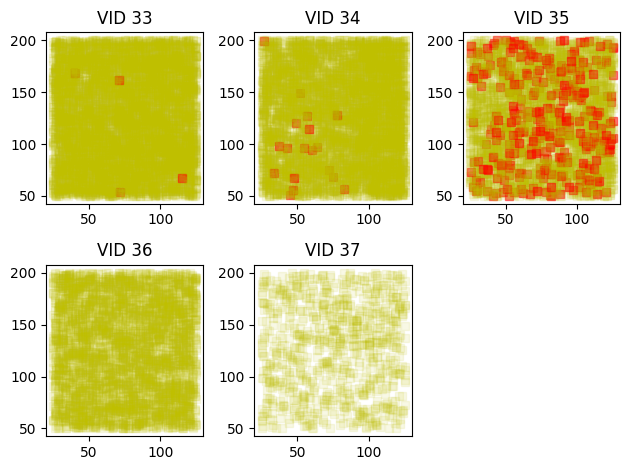

In [2]:
TABLE = 'mul_f7d1fa4'
settings = get_settings(TABLE).split(',')
print(f'Using settings:\n  {'\n  '.join(settings)}')

c.execute(f'SELECT DISTINCT voltage FROM {TABLE}')
voltages = [v for (v,) in c.fetchall()]
voltages.sort()

cols = ceil(sqrt(len(voltages)))
rows = ceil(len(voltages) / cols)

fig = plt.figure(layout="tight")
axs = {}
for i, voltage in enumerate(voltages):
	axs[voltage] = fig.add_subplot(rows, cols, i+1)
	axs[voltage].set_title(f'VID {voltage}')

c.execute(f'SELECT * FROM {TABLE}')
rows = c.fetchall()

summarize([GlitchResult[result_name] for (_, _, _, _, result_name, _, _, _, _) in rows])

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	glitch_values: GlitchSettings = {'ext_offset': ext_offset, 'width': width, 'voltage': voltage, 'prep_voltage': prep_voltage}
	result = GlitchResult[result_name]

	# if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
	if result == GlitchResult.NORMAL:
		continue
	axs[voltage].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)